In [4]:
import pandas
import numpy as np
pandas.set_option('display.max_columns', 20)
pandas.set_option('display.width', 350)
  
#read from google drive
data=pandas.read_csv("https://drive.google.com/uc?export=download&id=18RLruiMU8rM-IQPLdwL6wNEc8Kks2JZQ")
#fix ip address
data['ip_address']=round(data['ip_address'])
  
data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


In [5]:
#IP addresses Read from google drive
ip_addresses=pandas.read_csv("https://drive.google.com/uc?export=download&id=1wbKys6YI-IvE-b-C0_4xR4zz2YnpOL1d")
ip_addresses.head()

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


In [6]:
#Let's add the country to the original data set by using the ip address
data_country = [None] * data.shape[0]
  
for i in range(data.shape[0]):
    tmp = ip_addresses[(data['ip_address'][i] >= ip_addresses['lower_bound_ip_address']) & (data['ip_address'][i] <= ip_addresses['upper_bound_ip_address'])]['country'].values
    if(len(tmp)==1):  
        data_country[i] = tmp
data['country'] = data_country
#print(data)
data['country'] = data['country'].str.get(0)
#print(data)  
print(data.groupby('country').size().nlargest(10))

country
United States        58049
China                12038
Japan                 7306
United Kingdom        4490
Korea Republic of     4162
Germany               3646
France                3161
Canada                2975
Brazil                2961
Italy                 1944
dtype: int64


In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from datetime import datetime
np.random.seed(4684)

In [11]:
#make them dates
data["signup_time"]   = pandas.to_datetime(data["signup_time"])
data["purchase_time"] = pandas.to_datetime(data["purchase_time"])
#and take the difference
data['purchase_signup_diff'] =  (data["purchase_time"]-data["signup_time"]).dt.total_seconds()
  
#check how for each device id, how many different users had it
data['device_id_count'] = data.groupby('device_id')['device_id'].transform('count')
  
#check how for each ip address, how many different users had it
data['ip_address_count'] = data.groupby('ip_address')['ip_address'].transform('count')
#data set for the model. Drop first 3 vars and device id.
data_rf = data.drop(['user_id', 'signup_time', 'purchase_time', 'device_id'],axis=1)
  

In [12]:
#replace None in the country var with "Not_found"
data_rf['country'].replace([None], "Not_found", inplace=True)
#just keep the top 50 country, everything else is "other"
#get countries from 51 to last one
bottom_countries = data_rf.groupby('country').size().sort_values(ascending=False)[50:].index
x = dict.fromkeys(bottom_countries, 'Other')
data_rf['country'] = data_rf['country'].replace(x)


In [13]:
#make dummy
data_rf = pandas.get_dummies(data_rf, drop_first=True) 
  
#split into train and test to avoid overfitting
train, test = train_test_split(data_rf, test_size = 0.34)
  
#build the model
rf = RandomForestClassifier(n_estimators=100, max_features=3, oob_score=True)
rf.fit(train.drop('class', axis=1), train['class'])
  
#let's print OOB accuracy and confusion matrix
print(
"OOB accuracy is", 
rf.oob_score_, 
"\n", 
"OOB Confusion Matrix", 
"\n",
pandas.DataFrame(confusion_matrix(train['class'], rf.oob_decision_function_[:,1].round(), labels=[0, 1]))
)

OOB accuracy is 0.956403597605607 
 OOB Confusion Matrix 
        0     1
0  90362    83
1   4265  5023


In [14]:
#and let's print test accuracy and confusion matrix
print(
"Test accuracy is", rf.score(test.drop('class', axis=1),test['class']), 
"\n", 
"Test Set Confusion Matrix", 
"\n",
pandas.DataFrame(confusion_matrix(test['class'], rf.predict(test.drop('class', axis=1)), labels=[0, 1]))
)

Test accuracy is 0.955662819439849 
 Test Set Confusion Matrix 
        0     1
0  46481    35
1   2243  2620


Specially when dealing with fraud, you should always do the cut-off analysis. There is no reason why the default 0.5 value has to be the best one.

In [13]:
#We can double check that with a 0.5 cut-off we get the same results shown by rf output(since random forest internally uses 0.5)
#Predictions as probabilities
pred_prob=rf.predict_proba(test.drop('class', axis=1))[:,1]
#Predictions as actual classes
pred = rf.predict(test.drop('class', axis=1))
  
#Use 0.5 cutoff for probabilities. I.e. if larger > 0.5, predict 1, else predict 0. A short cut for this is using round function, which does exactly the same. If > 0.5, rounds to 1, else rounds to 0. Check if they are the same:
print(np.array_equal(pred_prob.round(), pred))

True


However, is really 0.5 the best possible cut-off? It really depends on what we are optimizing for. We therefore make a plot to check the ROC.

Text(0.5, 1.0, 'ROC')

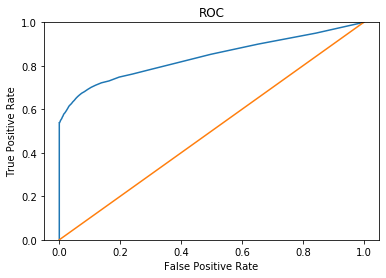

In [16]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
#Let's get false positive rate and true positive rate and plot them in the ROC
fpr, tpr, thresholds = roc_curve(test['class'],pred_prob)
#plot
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1])
plt.ylim([0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')


If we want to be a bit more accurate, we can use the approach of maximizing true positive rate - false positive rate, this is the same as maximizing (1-class1_error) - class0_error as we saw in the unbalanced data section.

In [19]:
#For consistency with R, we will focus on class errors, defined as class0_error = fpr and class1_error = 1 - tpr
error_cutoff=pandas.DataFrame({'cutoff':pandas.Series(thresholds),
                               'class0_error':pandas.Series(fpr),
                               'class1_error': 1 - pandas.Series(tpr)
                                })
print(error_cutoff)
error_cutoff['optimal_value'] = 1 - error_cutoff['class1_error'] - error_cutoff['class0_error']
print(error_cutoff.sort_values('optimal_value', ascending=False).head(1))

    cutoff  class0_error  class1_error
0     2.00      0.000000      1.000000
1     1.00      0.000000      0.527452
2     0.99      0.000000      0.492289
3     0.98      0.000000      0.481596
4     0.97      0.000000      0.474399
..     ...           ...           ...
71    0.04      0.380901      0.188155
72    0.03      0.497485      0.147029
73    0.02      0.653560      0.099938
74    0.01      0.842957      0.049558
75    0.00      1.000000      0.000000

[76 rows x 3 columns]
    cutoff  class0_error  class1_error  optimal_value
61    0.14       0.07348       0.32593       0.600589


# Feature engineering

In [15]:
# Get the time difference between purchase time and signup time
time_diff = data['purchase_time'] - data['signup_time']
time_diff = time_diff.apply(lambda x: x.seconds)
data['time_diff'] = time_diff

data['signup_day'] = data['signup_time'].apply(lambda x: x.dayofweek)
data['signup_week'] = data['signup_time'].apply(lambda x: x.week)

# Purchase day and week
data['purchase_day'] = data['purchase_time'].apply(lambda x: x.dayofweek)
data['purchase_week'] = data['purchase_time'].apply(lambda x: x.week)


columns = ['signup_day', 'signup_week', 'purchase_day', 'purchase_week', 'purchase_value', 'source', 
           'browser', 'sex', 'age', 'country', 'time_diff', 'device_id_count', 'ip_address_count', 'class']
data = data[columns]
data.head()

,signup_day,signup_week,purchase_day,purchase_week,purchase_value,source,browser,sex,age,country,time_diff,device_id_count,ip_address_count,class
0,1,9,5,16,34,SEO,Chrome,M,39,Japan,13882,1,1,0
1,6,23,0,24,16,Ads,Chrome,F,53,United States,17944,1,1,0
2,3,1,3,1,15,SEO,Opera,M,53,United States,1,12,12,1
3,1,18,0,19,44,SEO,Safari,M,41,None,60085,1,1,0
4,1,30,2,37,39,Ads,Safari,M,45,United States,41461,1,1,0


In [16]:
data_p = pandas.get_dummies(data) 
 
#split into train and test to avoid overfitting
train, test = train_test_split(data_p, test_size = 0.34)
  
#build the model
rf = RandomForestClassifier(n_estimators=100, max_features=5, oob_score=True)
rf.fit(train.drop('class', axis=1), train['class'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features=5, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=True, random_state=None,
                       verbose=0, warm_start=False)

In [30]:
top10_countries=data.groupby('country').size().sort_values(ascending=False)[0:10].index
print(top10_countries)

Index(['United States', 'China', 'Japan', 'United Kingdom', 'Korea Republic of', 'Germany', 'France', 'Canada', 'Brazil', 'Italy'], dtype='object', name='country')


In [17]:
print(
"OOB accuracy is", 
rf.oob_score_, 
"\n", 
"OOB Confusion Matrix", 
"\n",
pandas.DataFrame(confusion_matrix(train['class'], rf.oob_decision_function_[:,1].round(), labels=[0, 1]))
)

OOB accuracy is 0.95619303540453 
 OOB Confusion Matrix 
        0     1
0  90369    26
1   4343  4995


# Fraudulent Activity Identification

In [37]:
print(train.columns)
train_p=train.drop(['signup_day', 'signup_week', 'purchase_day', 'purchase_week'],axis=1)
print(train_p.columns)

Index(['signup_day', 'signup_week', 'purchase_day', 'purchase_week', 'purchase_value', 'age', 'time_diff', 'device_id_count', 'ip_address_count', 'class',
       ...
       'country_United States', 'country_Uruguay', 'country_Uzbekistan', 'country_Vanuatu', 'country_Venezuela', 'country_Viet Nam', 'country_Virgin Islands (U.S.)', 'country_Yemen', 'country_Zambia', 'country_Zimbabwe'],
      dtype='object', length=201)
Index(['purchase_value', 'age', 'time_diff', 'device_id_count', 'ip_address_count', 'class', 'source_Ads', 'source_Direct', 'source_SEO', 'browser_Chrome',
       ...
       'country_United States', 'country_Uruguay', 'country_Uzbekistan', 'country_Vanuatu', 'country_Venezuela', 'country_Viet Nam', 'country_Virgin Islands (U.S.)', 'country_Yemen', 'country_Zambia', 'country_Zimbabwe'],
      dtype='object', length=197)


Index(['purchase_value', 'age', 'time_diff', 'device_id_count', 'ip_address_count', 'class', 'source_Ads', 'source_Direct', 'source_SEO', 'browser_Chrome', 'browser_FireFox', 'browser_IE', 'browser_Opera', 'browser_Safari', 'sex_F', 'sex_M'], dtype='object')


NameError: name 'plt' is not defined

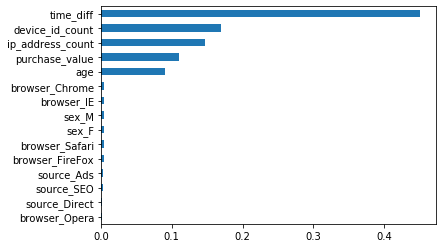

In [52]:
data_nc=data.drop(['signup_day', 'signup_week', 'purchase_day', 'purchase_week','country'],axis=1)
#print(data_nc.columns)
data_nc2=pandas.get_dummies(data_nc) 
print(data_nc2.columns)

train, test = train_test_split(data_nc2, test_size = 0.34)
rf = RandomForestClassifier(n_estimators=100, max_features=5, oob_score=True)
rf.fit(train.drop('class', axis=1), train['class'])
feat_importances = pandas.Series(rf.feature_importances_, index=train.drop(['class'],axis=1).columns)
feat_importances.sort_values().plot(kind='barh')


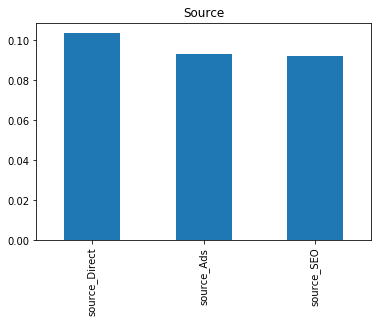

In [53]:
#check partial dependence plots for the variables.
#source
from pdpbox import pdp, info_plots
pdp_iso = pdp.pdp_isolate(model=rf, dataset=train, model_features=list(train.drop(['class'],axis=1)),feature=['source_Ads','source_Direct', 'source_SEO'],num_grid_points=50)
pdp_dataset = pandas.Series(pdp_iso.pdp, index=pdp_iso.display_columns)
pdp_dataset.sort_values(ascending=False).plot(kind='bar', title='Source')
